# _*Qiskit Aqua: Vehicle Routing*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorials.

***
### Contributors
Andrea Simonetto<sup>[1]</sup>, Jakub Marecek<sup>[1]</sup>, Martin Mevissen<sup>[1]</sup>

### Affiliation
- <sup>[1]</sup>IBMQ

## The Introduction

Logistics is a major industry, with some estimates valuing it at USD 8183 billion globally in 2015. Most service providers operate a number of vehicles (e.g., trucks and container ships), a number of depots, where the vehicles are based overnight, and serve a number of client locations with each vehicle during each day. There are many optimisation and control problems that consider these parameters. Computationally, the key challenge is how to design routes from depots to a number of client locations and back to the depot, so as to minimise vehicle-miles travelled, time spent, or similar objective functions. In this notebook we formalise an idealised version of the problem and showcase its solution using the quantum approximate optimization approach of Farhi, Goldstone, and Gutman (2014). 

The overall workflow we demonstrate comprises:

1. establish the client locations. Normally, these would be available ahead of the day of deliveries from a database. In our use case, we generate these randomly.

3. compute the pair-wise distances, travel times, or similar. In our case, we consider the Euclidean distance, "as the crow flies", which is perhaps the simplest possible.

4. compute the actual routes. This step is run twice, actually. First, we obtain a reference value by a run of a classical solver (IBM CPLEX) on the classical computer. Second, we run an alternative, hybrid algorithm partly on the quantum computer.

5. visualisation of the results. In our case, this is again a simplistic plot.

In the following, we first explain the model, before we proceed with the installation of the pre-requisites and the data loading.

## The Model 

Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. There are a number of formulations possible, extending a number of formulations of the travelling salesman problem [Applegate et al, 2006]. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. 

Let $n$ be the number of clients (indexed as $1,\dots,n$), and $K$ be the number of available vehicles. Let $x_{ij} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the segment from node $i$ to node $j$. The node index runs from $0$ to $n$, where $0$ is (by convention) the depot. There are twice as many distinct decision variables as edges. For example, in a fully connected graph, there are $n(n+1)$ binary decision variables. 

If two nodes $i$ and $j$ have a link from $i$ to $j$, we write $i \sim j$. We also denote with $\delta(i)^+$ the set of nodes to which $i$ has a link, i.e., $j \in \delta(i)^+$ if and only if $i \sim j$. Similarly, we denote with 
$\delta(i)^-$ the set of nodes which are connected to $i$, in the sense that $j \in \delta(i)^-$ if and only if $j \sim i$. 

In addition, we consider continuous variables, for all nodes $i = 1,\dots, n$, denoted $u_i$. These variables are needed in the MTZ formulation of the problem to eliminate sub-tours between clients. 

The VRP can be formulated as:

$$
(VRP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

subject to the node-visiting constraint:

$$
\sum_{j \in \delta(i)^+} x_{ij} = 1, \,\sum_{j \in \delta(i)^-} x_{ji} = 1,\, \forall i \in \{1,\dots,n\},
$$

the depot-visiting constraints:

$$
\sum_{i \in \delta(0)^+} x_{0i} = K, \, \sum_{j \in \delta(0)^-} x_{j0} = K,
$$

and the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

In particular, 
- The cost function is linear in the cost functions and weighs the different arches based on a positive weight $w_{ij}>0$ (typically the distance between node $i$ and node $j$);
- The first set of constraints enforce that from and to every client, only one link is allowed;
- The second set of constraints enforce that from and to the depot, exactly  $K$ links are allowed;
- The third set of constraints enforce the sub-tour elimination constraints and are bounds on $u_i$, with $Q>q_j>0$, and $Q,q_i \in \mathbb{R}$.


## Classical solution

We can solve the VRP classically, e.g., by using CPLEX. CPLEX uses a branch-and-bound-and-cut method to find an approximate solution of the VRP, which, in this formulation, is a mixed-integer linear program (MILP). For the sake of notation, we pack the decision variables in one vector as

$$
{\bf z} = [x_{01},x_{02},\ldots,x_{10}, x_{12},\ldots,x_{n(n-1)}]^T,
$$

wherein ${\bf z} \in \{0,1\}^N$, with $N = n (n+1)$. So the dimension of the problem scales quadratically with the number of nodes. Let us denote the optimal solution by ${\bf z}^*$, and the associated optimal cost $f^*$. 


## Quantum solution

Here, we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutman (2014). In particular, we use the variational quantum eigensolver (VQE). We stress that given the use of limited depth of the quantum circuits employed (variational forms), it is hard to discuss the speed-up of the algorithm, as the solution obtained is heuristic in nature. At the same time, due to the nature and importance of the target problems, it is worth investigating heuristic approaches, which may be worthwhile for some problem classes. 

Following [5], the algorithm can be summarised as follows:
- Preparation steps: 
	- Transform the combinatorial problem into a binary polynomial optimization problem with equality constraints only;
	- Map the resulting problem into an Ising Hamiltonian ($H$) for variables ${\bf z}$ and basis $Z$, via penalty methods if necessary;
	- Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
	- Choose a set of controls $\theta$ and make a trial function $\big|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$.


- Algorithm steps: 
	- Evaluate $C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)\big|H\big|\psi(\boldsymbol\theta)\rangle$ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen.
	- Use a classical optimizer to choose a new set of controls.
	- Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.
	- Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $\Big|\langle z_i\big|\psi(\boldsymbol\theta)\rangle\Big|^2\;\forall i$ to obtain the answer.


There are many parameters throughout, notably the choice of the trial wavefunction. Below, we consider:

$$
\big|\psi(\theta)\rangle = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m \big|+\rangle
$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully-entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^N Y(\theta_{i})$, where $N$ is the number of qubits and $m$ is the depth of the quantum circuit. 


### Construct the Ising Hamiltonian

From $VRP$ one can construct a binary polynomial optimization with equality constraints only by considering cases in which $K=n-1$. In these cases the sub-tour elimination constraints are not necessary and the problem is only on the variable ${\bf z}$. In particular, we can write an augmented Lagrangian as

$$
(IH) \quad H = \sum_{i \sim j} w_{ij} x_{ij}  + A \sum_{i \in \{1,\dots,n\}} \Big(\sum_{j \in \delta(i)^+} x_{ij} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big(\sum_{j \in \delta(i)^-} x_{ji} - 1\Big)^2 +A \Big(\sum_{i \in \delta(0)^+} x_{0i} - K\Big)^2 + A\Big(\sum_{j \in \delta(0)^+} x_{j0} - K\Big)^2
$$

where $A$ is a big enough parameter. 

### From Hamiltonian to QP formulation 

In the vector ${\bf z}$, and for a complete graph ($\delta(i)^+ = \delta(i)^- = \{0,1,\dots,i-1,i+1,\dots,n\}$), $H$ can be written as follows.

$$
\min_{{\bf z}\in \{0,1\}^{n(n+1)}} {\bf w}^T {\bf z}  + A \sum_{i \in \{1,\dots,n\}} \Big({\bf e}_i \otimes {\bf 1}_n^T {\bf z} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big({\bf v}_i^T {\bf z} - 1\Big)^2 + A \Big(({\bf e}_0 \otimes {\bf 1}_n)^T{\bf z} - K\Big)^2 + A\Big({\bf v}_0^T{\bf z} - K\Big)^2.
$$

That is:

$$
\min_{\bf z\in \{0,1\}^{n(n+1)}} \bf z^T {\bf Q} \bf z + {\bf g}^T \bf z + c,
$$

Where: first term:

$$
{\bf Q} = A \sum_{i \in \{0,1,\dots,n\}}  \Big[({\bf e}_i \otimes {\bf 1}_n)({\bf e}_i \otimes {\bf 1}_n)^T + {\bf v}_i{\bf v}_i^T \Big] 
$$

Second term:

$$
{\bf g} = {\bf w} -2 A \sum_{i \in \{1,\dots,n\}} \Big[({\bf e}_i \otimes {\bf 1}_n) + {\bf v}_i \Big] -2 A K \Big[({\bf e}_0 \otimes {\bf 1}_n) + {\bf v}_0 \Big]
$$

Third term:

$$
c = 2An +2AK^2.
$$

The QP formulation of the Ising Hamiltonian is ready for the use of VQE. 



## References

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028, 2014

[2] https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/aqua/optimization/maxcut_and_tsp.ipynb

[3] C. E. Miller, E. W. Tucker, and R. A. Zemlin (1960). "Integer Programming Formulations and Travelling Salesman Problems". J. ACM. 7: 326–329. doi:10.1145/321043.321046.

[4] D. L. Applegate, R. M. Bixby, V. Chvátal, and W. J. Cook (2006). The Traveling Salesman Problem. Princeton University Press, ISBN 978-0-691-12993-8.

## Initialization

First of all we load all the packages that we need: 
  - Python 3.6 or greater is required;
  - CPLEX 12.8 or greater is required for the classical computations;
  - Latest Qiskit is required for the quantum computations.

In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math

# Qiskit packages
from qiskit.quantum_info import Pauli
from qiskit.aqua.input import EnergyInput
from qiskit.aqua import Operator, run_algorithm

# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

In [2]:
from datetime import datetime
print("TimeStamp =", datetime. now())
!pip show qiskit

TimeStamp = 2019-09-11 16:22:45.283037
Name: qiskit
Version: 0.10.1
Summary: Software for developing quantum computing programs
Home-page: https://github.com/Qiskit/qiskit
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages
Requires: qiskit-terra, qiskit-aer, qiskit-ibmq-provider, qiskit-ignis, qiskit-aqua, qiskit-chemistry
Required-by: 


We then initialize the variables

In [3]:
# Initialize the problem by defining the parameters
K = 2    # number of vehicles
n = K+1  # number of nodes + depot (n+1)


We define an initializer class that randomly places the nodes in a 2-D plane and computes the distance between them. 

In [4]:
# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [5]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

## Classical solution using IBM ILOG CPLEX

For a classical solution, we use IBM ILOG CPLEX. CPLEX is able to find the exact solution of this problem. We first define a ClassicalOptimizer class that encodes the problem in a way that CPLEX can solve, and then instantiate the class and solve it. 


In [6]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [7]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [8]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

CPLEX may be missing.


In [9]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x: visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

If you have CPLEX, the solution shows the depot with a star and the selected routes for the vehicles with arrows. 

## Quantum solution from the ground up

For the quantum solution, we use Qiskit. 

First, we derive the solution from the ground up, using a class QuantumOptimizer that encodes the quantum approach to solve the problem and then we instantiate it and solve it. We define the following methods inside the class:
- `binary_representation` : encodes the problem $(M)$ into a the Ising Hamiltonian QP (that's basically linear algebra);
- `construct_hamiltonian` : constructs the Ising Hamiltonian in terms of the $Z$ basis;
- `check_hamiltonian` : makes sure that the Ising Hamiltonian is correctly encoded in the $Z$ basis: to do this, it solves a eigenvalue-eigenvector problem for a symmetric matrix of dimension $2^N \times 2^N$. For the problem at hand $n=3$, that is $N = 12$ seems the limit; 
- `vqe_solution` : solves the problem $(M)$ via VQE by using the SPSA solver (with default parameters);
- `_q_solution` : internal routine to represent the solution in a usable format.


In [10]:
class QuantumOptimizer:

    def __init__(self, instance, n, K, max_trials=1000):

        self.instance = instance
        self.n = n
        self.K = K
        self.max_trials = max_trials

    def binary_representation(self,x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for ii in range(n):
            count = ii-1
            for jj in range(n*(n-1)):

                if jj//(n-1) == ii:
                    count = ii

                if jj//(n-1) != ii and jj%(n-1) == count:
                    v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q,g,c,cost

    def construct_hamiltonian(self):

        instance = self.instance
        n = self.n
        K = self.K

        N = (n - 1) * n  # number of qubits
        Q,g,c,_ = self.binary_representation()

        # Defining the new matrices in the Z-basis

        Iv = np.ones(N)
        Qz = (Q / 4)
        gz = (-g / 2 - np.dot(Iv, Q / 4) - np.dot(Q / 4, Iv))
        cz = (c + np.dot(g / 2, Iv) + np.dot(Iv, np.dot(Q / 4, Iv)))

        cz = cz + np.trace(Qz)
        Qz = Qz - np.diag(np.diag(Qz))

        # Getting the Hamiltonian in the form of a list of Pauli terms

        pauli_list = []
        for i in range(N):
            if gz[i] != 0:
                wp = np.zeros(N)
                vp = np.zeros(N)
                vp[i] = 1
                pauli_list.append((gz[i], Pauli(vp, wp)))
        for i in range(N):
            for j in range(i):
                if Qz[i, j] != 0:
                    wp = np.zeros(N)
                    vp = np.zeros(N)
                    vp[i] = 1
                    vp[j] = 1
                    pauli_list.append((2 * Qz[i, j], Pauli(vp, wp)))

        pauli_list.append((cz, Pauli(np.zeros(N), np.zeros(N))))

        return cz, pauli_list

    def check_hamiltonian(self):

        cz, op = self.construct_hamiltonian()
        Op = Operator(paulis=op)

        qubitOp, offset = Op, 0
        algo_input = EnergyInput(qubitOp)

        # Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

        algorithm_cfg = {
            'name': 'ExactEigensolver',
        }

        params = {
            'problem': {'name': 'ising'},
            'algorithm': algorithm_cfg
        }
        result = run_algorithm(params, algo_input)

        quantum_solution = self._q_solution(result['eigvecs'][0],self.n*(self.n+1))
        ground_level = result['energy'] + offset

        return quantum_solution, ground_level

    def vqe_solution(self):

        cz, op = self.construct_hamiltonian()
        Op = Operator(paulis=op)

        qubitOp, offset = Op, cz
        algo_input = EnergyInput(qubitOp)


        algorithm_cfg = {
            'name': 'VQE',
            'operator_mode': 'paulis'
        }

        optimizer_cfg = {
            'name': 'SPSA',
            'max_trials': self.max_trials
        }

        var_form_cfg = {
            'name': 'RY',
            'depth': 5,
            'entanglement': 'linear'
        }

        params = {
            'problem': {'name': 'ising', 'random_seed': 10598},
            'algorithm': algorithm_cfg,
            'optimizer': optimizer_cfg,
            'variational_form': var_form_cfg,
            'backend': {'name': 'qasm_simulator'
                        }
        }

        result = run_algorithm(params, algo_input)

        #quantum_solution = self._q_solution(result['eigvecs'][0], self.n * (self.n + 1))
        quantum_solution_dict = result['eigvecs'][0]

        q_s = max(quantum_solution_dict.items(), key=operator.itemgetter(1))[0]
        quantum_solution= [int(chars) for chars in q_s]
        quantum_solution = np.flip(quantum_solution, axis=0)

        _,_,_,level = self.binary_representation(x_sol=quantum_solution)
        return quantum_solution_dict, quantum_solution, level

    def _q_solution(self, v, N):

        index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
        string_value = "{0:b}".format(index_value)

        while len(string_value)<N:
            string_value = '0'+string_value

        sol = list()
        for elements in string_value:
            if elements == '0':
                sol.append(0)
            else:
                sol.append(1)

        sol = np.flip(sol, axis=0)

        return sol

### Step 1

Instantiate the quantum optimizer class with parameters: 
- the instance;
- the number of nodes and vehicles `n` and `K`;
- the number of iterations for SPSA in VQE (default 1000)

In [11]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(instance,n,K, 100)

### Step 2

Encode the problem as a binary formulation (IH-QP).

Sanity check: make sure that the binary formulation in the quantum optimizer is correct (i.e., yields the same cost given the same solution).

In [12]:
# Check if the binary representation is correct
try:
    if z:
        Q,g,c,binary_cost = quantum_optimizer.binary_representation(x_sol = z)
        print(binary_cost,classical_cost)
        if np.abs(binary_cost - classical_cost)<0.01:
            print('Binary formulation is correct')
        else: print('Error in the binary formulation')
    else:
        print('Could not verify the correctness, due to CPLEX solution being unavailable.')
        Q,g,c,binary_cost = quantum_optimizer.binary_representation()
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Could not verify the correctness, due to CPLEX solution being unavailable.


### Step 3

Encode the problem as an Ising Hamiltonian in the Z basis. 

Sanity check: make sure that the formulation is correct (i.e., yields the same cost given the same solution)

In [13]:
ground_state, ground_level = quantum_optimizer.check_hamiltonian()
print(ground_state)

if z:
    if np.abs(ground_level - classical_cost)<0.01:
        print('Ising Hamiltonian in Z basis is correct')
    else: print('Error in the Ising Hamiltonian formulation')

[1 1 1 0 1 0 0 0 0 0 0 0]


### Step 4

Solve the problem via VQE. N.B. Depending on the number of qubits, the state-vector simulation can can take a while; for example with 12 qubits, it takes more than 12 hours. Logging useful to see what the program is doing.

In [14]:
quantum_dictionary, quantum_solution, quantum_cost = quantum_optimizer.vqe_solution()

print(quantum_solution, quantum_cost)

[1 1 1 0 1 0] 132.11148115684045


### Step 5
Visualize the solution

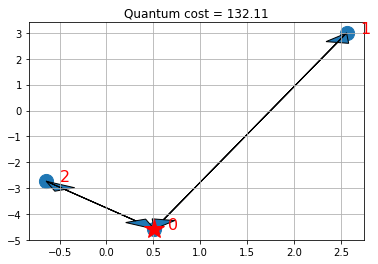

In [15]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, 'Quantum')
                   
# and visualize the classical for comparison
if x: visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

The plots present the depot with a star and the selected routes for the vehicles with arrows. Note that in this particular case, we can find the optimal solution of the QP formulation, which happens to coincide with the optimal solution of the ILP.

Keep in mind that VQE is an heuristic working on the QP formulation of the Ising Hamiltonian, though. For suitable choices of A, local optima of the QP formulation will be feasible solutions to the ILP. While for some small instances, as above, we can find optimal solutions of the QP formulation which coincide with optima of the ILP, finding optimal solutions of the ILP is harder than finding local optima of the QP formulation, in general, which in turn is harder than finding feasible solutions of the ILP. Even within the VQE, one may provide stronger guarantees, for specific variational forms (trial wave functions). 

Last but not least, you may be pleased to learn that the above has been packaged in Qiskit Aqua.

In [16]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.translators.ising.vehicle_routing import *

qubitOp = get_vehiclerouting_qubitops(instance, n, K)
backend = BasicAer.get_backend('statevector_simulator')
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_transpiler=seed)
result = vqe.run(quantum_instance)
# print(result)
x_quantum2 = get_vehiclerouting_solution(instance, n, K, result)
print(x_quantum2)
quantum_cost2 = get_vehiclerouting_cost(instance, n, K, x_quantum2)
print(quantum_cost2)

[1 1 1 0 0 1]
12434.909288240102


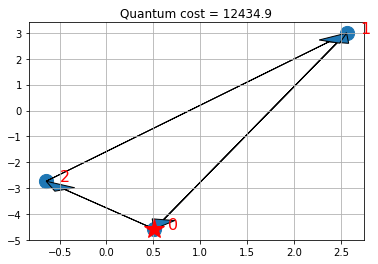

In [17]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = x_quantum2[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost2, n, K, 'Quantum')

In [18]:
print("TimeStamp =", datetime. now())
!pip show qiskit

TimeStamp = 2019-09-11 16:24:34.051945
Name: qiskit
Version: 0.10.1
Summary: Software for developing quantum computing programs
Home-page: https://github.com/Qiskit/qiskit
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages
Requires: qiskit-terra, qiskit-aer, qiskit-ibmq-provider, qiskit-ignis, qiskit-aqua, qiskit-chemistry
Required-by: 
